In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from np_extractor import extract_NPs, definition_NPs, NP_compare

In [17]:
import random
from collections import defaultdict

In [18]:
import requests
import json

def smallworldscore(word):
    url = f"https://smallworldofwords.org/search/en/dictionary/all/{word}/click"
    word_stats = json.loads(requests.get(url).text)
    return word_stats

In [37]:
d = defaultdict(lambda: (0, int))

In [38]:
d['a'] = (3, 1)
d['b']

(0, int)

In [54]:
class WordTable():

    def __init__(self, category, wordlist):
        self.category = category
        self.score = defaultdict(int)
        for word in wordlist:
            self.score[word] = 0

        self.SWS = self.buildSWS()
        self.DEF = self.buildDefinition()
        
    def resetScore(self):
        self.score = self.score.fromkeys(self.score, 0)

    def buildSWS(self):
        SWS = defaultdict(lambda: defaultdict(lambda: (0,int)))
        for word in self.score:
            sws_tree = smallworldscore(word)
            forward = sws_tree['forward']
            backward = sws_tree['backward']

            for score in forward:
                SWS[word][score['word']] = (score['freq']/100, 0)
            for score in backward:
                SWS[word][score['word']] = (score['freq']/100, 1)

        return SWS
            
    def assocScore(self, related_word):
        total_score = 0
        for word in self.score:
            self.score[word] += self.SWS[word][related_word][0]
            total_score += self.SWS[word][related_word][0]
            #print(f'keyword {word} added score by {self.SWS[word][related_word]} with {related_word}')
        return total_score

    def buildDefinition(self):
        DEF = {}
        for word in self.score:
            definition, NPs = definition_NPs(self.category, word)
            DEF[word] = {"definition" : definition, "NPs" : NPs}

        return DEF

    def sentenceScore(self, description):
        
        definition, des_NPs = extract_NPs(description)
        #print(des_NPs)
        keywords = []

        for word in self.score:
            NPs = self.DEF[word]["NPs"]
            for des_NP in des_NPs:
                if NP_compare(NPs, des_NP):
                    keywords += [w for w, _ in des_NP]
                    self.score[word] += 1
                    #print(f'keyword {word} added score by 1 with {des_NP}')

        for NP in des_NPs:
            for word, tag in NP:
                if tag.startswith('JJ') or tag.startswith('NN'):
                    total_score = self.assocScore(word)
                    if total_score > 0:
                        keywords.append(word)

        return list(set(keywords))

    def plot(self, size = 5):
        np_values = np.array(list(self.score.values()))
        np_keys = np.array(list(self.score.keys()))

        np_values = np_values.reshape(size, size)
        np_keys = np_keys.reshape(size, size)

        ax = plt.figure(figsize=(10, 7))
        df = pd.DataFrame(np_values)
        annot = [["{}\n{}".format(np_keys[i][j], np_values[i][j]) for j in range(size)] for i in range(size)]
        ax = sns.heatmap(df, annot=annot, fmt ='', annot_kws={'size' : 10})

In [55]:
wordtable = WordTable("animals", ['rabbit', 'dog', 'cat', 'frog'])

In [56]:
def NP_compare(definitions, des_NP):

    Noun = 0
    Adj = 0
    
    for def_NP in definitions:
        for word, tag in des_NP:
            if tag.startswith('NN'):
                if word in [w for w, _ in def_NP]:
                    Noun += 1 
            if not tag.startswith('DT'):
                if word in [w for w, _ in def_NP]:
                    Adj += 1

    if Noun and Adj:
        return True
    return False

In [57]:
definition, NPs = definition_NPs('animals', 'rabbit')
description, des_NPs = extract_NPs("It has long ears.")

print(des_NPs)
print(NPs)
for des_NP in des_NPs:
    print(NP_compare(NPs, des_NP))

[[('long', 'RB'), ('ears', 'NNS')]]
[[('A', 'DT'), ('rabbit', 'NN')], [('a', 'DT'), ('small', 'JJ'), ('furry', 'NN'), ('animal', 'NN')], [('long', 'JJ'), ('ears', 'NNS')], [('Rabbits', 'NNS')], [('pets', 'NNS')], [('live', 'JJ'), ('wild', 'NN')], [('holes', 'NNS')], [('the', 'DT'), ('ground', 'NN')]]
True


['ground', 'the', 'furry']
['long', 'cute', 'ears']
['small', 'animal']


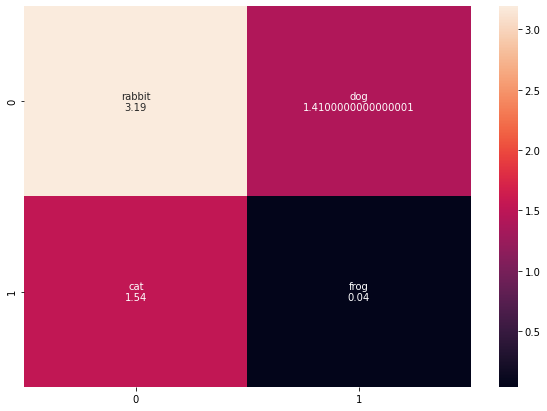

In [58]:
## When description is "It is furry and it lives in the ground."

wordtable.resetScore()

#wordtable.assocScore('furry')
#wordtable.assocScore('ground')

print(wordtable.sentenceScore("It is furry, and it lives in the ground."))
print(wordtable.sentenceScore("It is really cute, and has long ears."))
print(wordtable.sentenceScore("It is small animal."))

wordtable.plot(size = 2)
